In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [31]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])

df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values('ds')
df.head()

Saving tourist_arrivals.csv to tourist_arrivals (2).csv


,ds,y
0,2023-01-01,2246
1,2023-01-02,3633
2,2023-01-03,2982
3,2023-01-04,2694
4,2023-01-05,3512


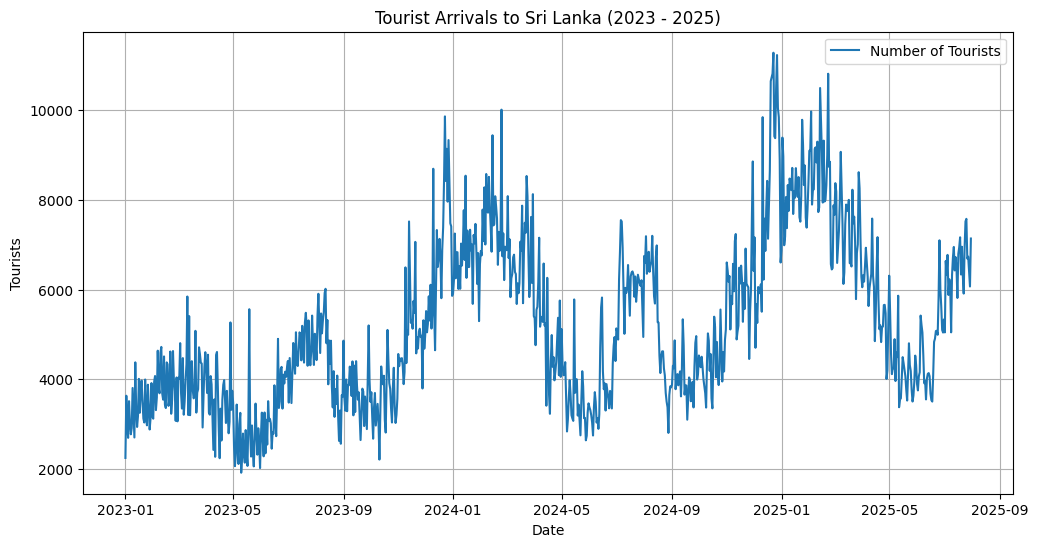

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Number of Tourists')
plt.title('Tourist Arrivals to Sri Lanka (2023 - 2025)')
plt.xlabel('Date')
plt.ylabel('Tourists')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
train = df[df['ds'] < '2025-01-01'].copy()
test = df[df['ds'] >= '2025-01-01'].copy()

In [34]:
model1 = Prophet()
model1.fit(train)

future1 = model1.make_future_dataframe(periods=len(test), freq='D')
forecast1 = model1.predict(future1)

forecast1_test = forecast1[['ds', 'yhat']].tail(len(test)).copy()
forecast1_test.rename(columns={'yhat': 'y_pred_normal'}, inplace=True)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzd3ykp19/1zv5oui8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzd3ykp19/gb6y5uup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12249', 'data', 'file=/tmp/tmpzd3ykp19/1zv5oui8.json', 'init=/tmp/tmpzd3ykp19/gb6y5uup.json', 'output', 'file=/tmp/tmpzd3ykp19/prophet_model1iq9he1z/prophet_model-20250805170949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
train2 = train.copy()
test2 = test.copy()
train2['month'] = train2['ds'].dt.month
test2['month'] = test2['ds'].dt.month

train2 = pd.get_dummies(train2, columns=['month'], prefix='month')
test2 = pd.get_dummies(test2, columns=['month'], prefix='month')

missing_cols = set(train2.columns) - set(test2.columns)
for col in missing_cols:
    if col.startswith('month_'):
        test2[col] = 0
test2 = test2[train2.columns]

future2 = pd.concat([train2, test2]).drop(columns=['y'])

model2 = Prophet()
for col in train2.columns:
    if col.startswith('month_'):
        model2.add_regressor(col)

model2.fit(train2)

forecast2 = model2.predict(future2)
forecast2_test = forecast2[['ds', 'yhat']].tail(len(test)).copy()
forecast2_test.rename(columns={'yhat': 'y_pred_month_reg'}, inplace=True)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzd3ykp19/axhpsw93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzd3ykp19/nm7lael4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10051', 'data', 'file=/tmp/tmpzd3ykp19/axhpsw93.json', 'init=/tmp/tmpzd3ykp19/nm7lael4.json', 'output', 'file=/tmp/tmpzd3ykp19/prophet_modelrx_4_i11/prophet_model-20250805171022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [36]:
results = test[['ds', 'y']].copy()
results = results.merge(forecast1_test, on='ds')
results = results.merge(forecast2_test, on='ds')

In [37]:
def evaluate(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} MAE: {mae:.2f}, RMSE: {rmse:.2f}")

evaluate(results['y'], results['y_pred_normal'], 'Standard Prophet')
evaluate(results['y'], results['y_pred_month_reg'], 'Prophet + Month Regressor')

Standard Prophet MAE: 1107.42, RMSE: 1277.87
Prophet + Month Regressor MAE: 746.17, RMSE: 889.97


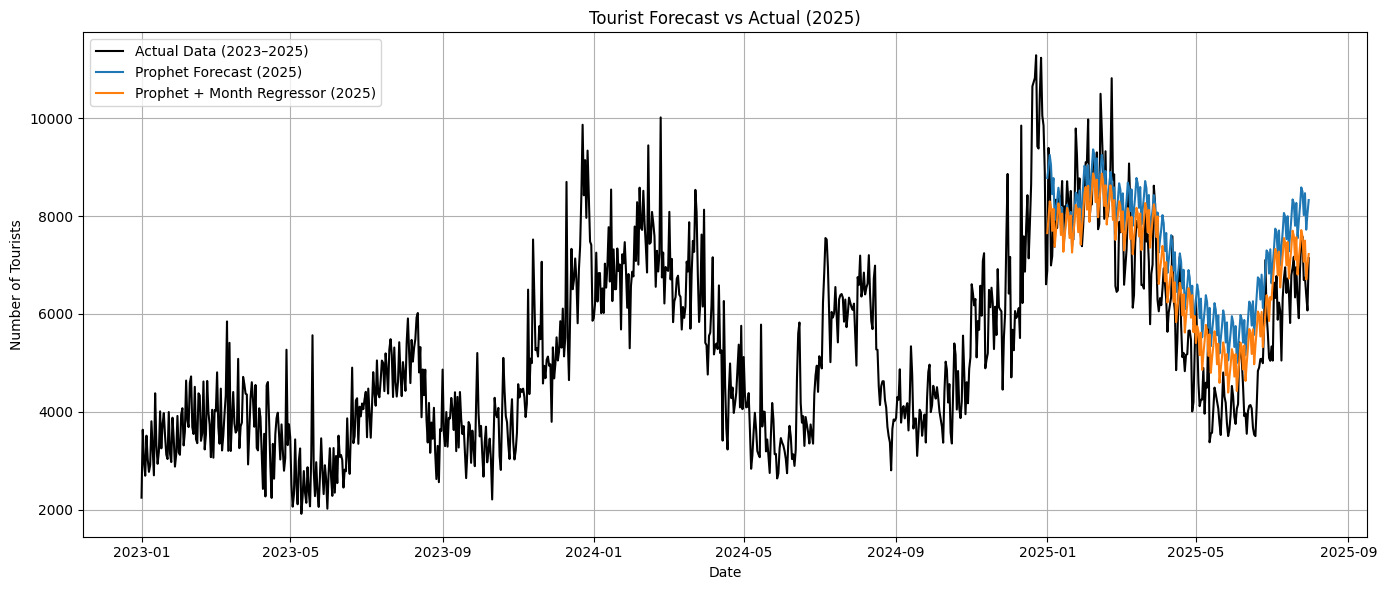

In [47]:
plt.figure(figsize=(14, 6))

plt.plot(df['ds'], df['y'], label='Actual Data (2023–2025)', color='black')

plt.plot(results['ds'], results['y_pred_normal'], label='Prophet Forecast (2025)')
plt.plot(results['ds'], results['y_pred_month_reg'], label='Prophet + Month Regressor (2025)')

plt.title('Tourist Forecast vs Actual (2025)')
plt.xlabel('Date')
plt.ylabel('Number of Tourists')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
results.to_csv('prophet_forecast_comparison.csv', index=False)